In [131]:
import pandas as pd
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from dask_ml.model_selection import GridSearchCV 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from shapely.geometry import Polygon
from h3 import h3

## Helper functions

In [132]:
# Split and normalize data

def prep_data(df, h3=False, resolution=None):
    # split dependent from independent variables
    df = df.dropna()
    y = df.ntrips 
    X = df.drop(columns=["date", "ntrips"])
    
    # convert h3 string to int
    if h3:
        X[f"h3_{resolution}"] = X[f"h3_{resolution}"].apply(int, base=16)
        
    # train test and validation split
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.30, random_state=34)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=(0.2/0.7),random_state=34)
    
    # scale data
    X_train_norm = StandardScaler().fit_transform(X_train)
    X_test_norm = StandardScaler().fit_transform(X_test)
    X_val_norm = StandardScaler().fit_transform(X_val)
    
    
    return X_train_norm, X_test_norm, X_val_norm, y_train, y_test, y_val, X_train, X_test, X_val

In [133]:
# Plotting function

def plot_prediction(X_tr, y_tr, X_te, y_pr, column, figsize=(8,6), alpha=0.4):
    plt.figure(figsize=figsize)
    plt.title("Observed vs predicted demand for " + column + " feature")
    plt.scatter(X_tr[column], y_tr, marker="x", c='royalblue', alpha=alpha)
    plt.xlabel(column)
    plt.ylabel("Demand")
    plt.scatter(X_te[column], y_pr, marker="x", c='coral', alpha=alpha)
    plt.legend(['Observed data', 'fitted data'])

def plot_matrix(X_tr, y_tr, X_te, y_pr, path=None, figsize=(20,4), alpha=0.4):
    xs = np.linspace(0,100,100)
    fig, axs = plt.subplots(nrows=1, ncols=len(X_tr.columns), figsize=figsize)
    plt.suptitle("Observed vs predicted demand for each feature")
    axs[0].set_ylabel("Demand")
    axs[0].scatter(X_tr[X_tr.columns[0]], y_tr, marker="x", c='royalblue', alpha=alpha)
    axs[0].scatter(X_te[X_tr.columns[0]], y_pr, marker="x", c='coral', alpha=alpha)
    axs[0].set_xlabel(X_tr.columns[0])
    axs[0].legend(['observed data', 'fitted data'])
    for i in range(1,len(X_tr.columns)):
        axs[i].scatter(X_tr[X_tr.columns[i]], y_tr, marker="x", c='royalblue', alpha=alpha)
        axs[i].scatter(X_te[X_tr.columns[i]], y_pr, marker="x", c='coral', alpha=alpha)
        axs[i].set_xlabel(X_tr.columns[i])
    fig.tight_layout()
    if (path != None):
        #Create directory if it does not exist
        if not os.path.exists(os.path.dirname("plots/")):
            os.makedirs(os.path.dirname("plots/"))

        plt.savefig(f"plots/{path}")
        plt.close(fig)

In [134]:
# Metrics function

def get_metrics(y_train, y_pred_train, y_test, y_pred_test):

    return {
            "MAE": {
                    "train": mean_absolute_error(y_train, y_pred_train),
                    "test": mean_absolute_error(y_test, y_pred_test)
                }, 
            "r2": {
                    "train": r2_score(y_train, y_pred_train),
                    "test": r2_score(y_test, y_pred_test)
                }
    }

In [135]:
def get_n_poi_for_resolution(resolution="h3_3"):
    # get polygons from hexagon id
    df_hex = gpd.read_file("hexagons.csv", index_col=[0])
    df_hex = df_hex[resolution].to_frame()
    df_hex['geometry'] = df_hex.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x[resolution], geo_json=True)), axis=1)
    df_hex = df_hex.set_geometry("geometry")
    df_hex.crs = "EPSG:4326"
    df_hex = df_hex.to_crs("EPSG:4326")
    
    # load point of interest
    poi = gpd.read_file("POI.geojson")
    
    # join
    poi_by_hex = gpd.sjoin(poi, df_hex, how='inner', op='within')
    
    return poi_by_hex.groupby(resolution).size().to_frame().reset_index().rename(columns={0:"n_poi"})

In [136]:
def get_n_poi_for_resolution_and_amenity(resolution="h3_3"):
    # get polygons from hexagon id
    df_hex = gpd.read_file("hexagons.csv", index_col=[0])
    df_hex = df_hex[resolution].to_frame()
    df_hex['geometry'] = df_hex.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x[resolution], geo_json=True)), axis=1)
    df_hex = df_hex.set_geometry("geometry")
    df_hex.crs = "EPSG:4326"
    df_hex = df_hex.to_crs("EPSG:4326")
    
    # load point of interest
    poi = gpd.read_file("POI.geojson")
    
    # join
    poi_by_hex = gpd.sjoin(poi, df_hex, how='inner', op='within').groupby([resolution, "amenity"]).size().to_frame().reset_index()
    
    # generate according dataframe with features
    poi_features = []
    for hexagon in poi_by_hex[resolution].unique():
        di = {resolution: hexagon}
        for amenity in poi_by_hex.amenity.unique():
            n = poi_by_hex[(poi_by_hex[resolution] == hexagon) & (poi_by_hex["amenity"] == amenity)][0].values
            di[amenity] = n[0] if n.size > 0 else 0
        poi_features.append(di)
    
    return pd.DataFrame(poi_features)

In [137]:
def svr_fit_eval(X_train_norm, y_train, X_test_norm, X_test, y_test):
    '''Fit an svr model and return results.'''
    svr = SVR(kernel='rbf', epsilon=200 , gamma='scale', C=10000)

    # Fit the SVR model
    svr.fit(X_train_norm, y_train)

    # Predict on the test set
    y_pred_test = svr.predict(X_test_norm)
    y_pred_train = svr.predict(X_train_norm)

    # Evaluate the model
    result = get_metrics(y_train, y_pred_train, y_test, y_pred_test)

    return svr, result, y_pred_test, y_pred_train

In [138]:
def eval_svr(resolution, time_bin, poi_agg=False, poi=False):
    '''Fit and evaluate different svr models using different datasets.'''
    # load data
    df = pd.read_csv(f"prep_data/h3_{resolution}/h3_{resolution}_time_bin_{time_bin}.csv", index_col=[0]).dropna()
    
    if poi_agg:
        poi_by_hex = get_n_poi_for_resolution(f"h3_{resolution}")
        df = df.merge(poi_by_hex, how="left", on=f"h3_{resolution}")
    elif poi:
        poi_by_hex = get_n_poi_for_resolution_and_amenity(f"h3_{resolution}")
        df = df.merge(poi_by_hex, how="left", on=f"h3_{resolution}")
        
    # split whole data
    X_train_norm, X_test_norm, X_val_norm, y_train, y_test, y_val, X_train, X_test, X_val = prep_data(df, True, resolution)
    
    # fit model
    _, result, __, ___ = svr_fit_eval(X_train_norm, y_train, X_test_norm, X_test, y_test)
    
    return result

## Load Data

In [139]:
# read data
df = pd.read_csv("prep_data/h3_3/h3_3_time_bin_1.csv", index_col=[0]).dropna()

## Gridsearch

In [140]:
def tune_svr(X, y):
    # Define the parameter grid
    param_grid = {
        'C': [5000, 10000, 12000],
        'epsilon': [40, 50, 100, 200, 400],
        'kernel': ['linear', 'poly', 'rbf'],
        'gamma': ['scale', 'auto'],
    }

    # Create the SVR model
    svr = SVR()

    # Create the GridSearchCV object
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid)

     # Perform grid search
    grid_search.fit(X, y)
  
    # Return cv results
    return grid_search.best_params_

In [141]:
# take a sample
df_sample = df.sample(1000)

In [142]:
# split the sample data
X_train_norm, X_test_norm, X_val_norm, y_train, y_test, y_val, _, __, ___ = prep_data(df_sample, True, 3)

In [143]:
# perfom gridsearch
tune_svr(X_train_norm, y_train)

{'C': 10000, 'epsilon': 40, 'gamma': 'auto', 'kernel': 'rbf'}

## Split data

In [144]:
# split whole data
X_train_norm, X_test_norm, X_val_norm, y_train, y_test, y_val, X_train, X_test, X_val = prep_data(df, True, 3)

## 1. SVR

{'MAE': {'train': 266.03827123836834, 'test': 302.6077767843045},
 'r2': {'train': 0.9091547362966366, 'test': 0.8779337219399584}}

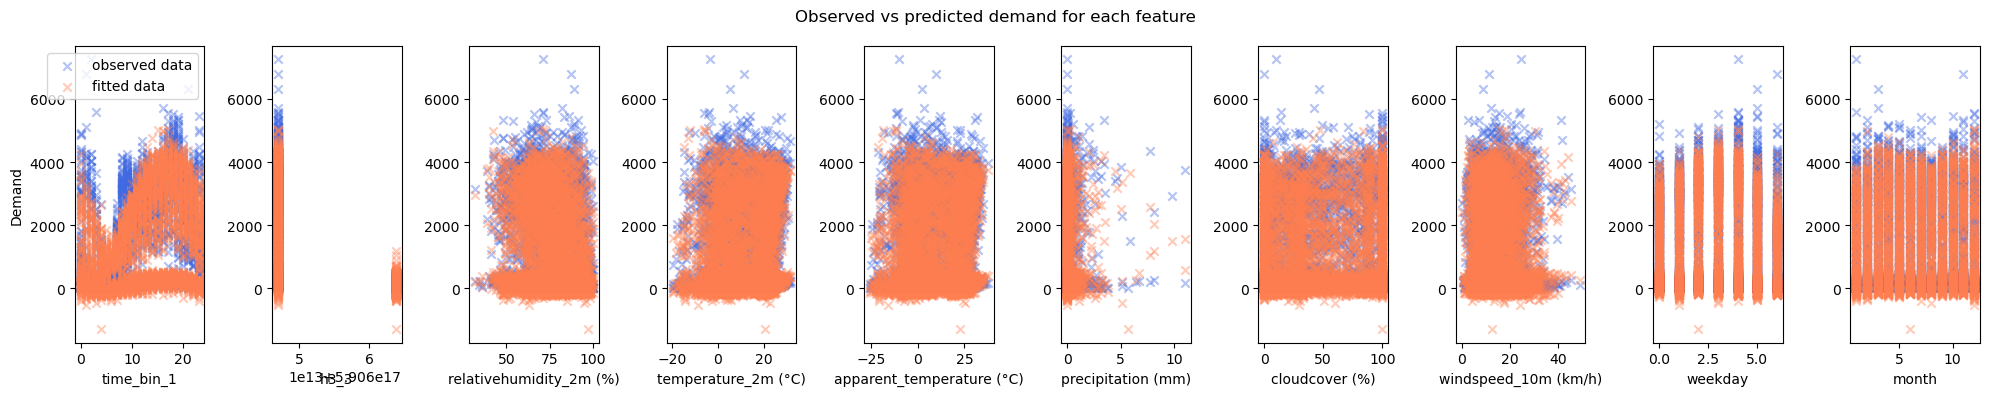

In [145]:
svr = SVR(kernel='rbf', epsilon=200 , gamma='scale', C=10000)

# Fit the SVR model
svr.fit(X_train_norm, y_train)

# Predict on the test set
y_pred_test = svr.predict(X_test_norm)
y_pred_train = svr.predict(X_train_norm)

# Evaluate the model
result = get_metrics(y_train, y_pred_train, y_test, y_pred_test)
display(result)

# Plot 
plot_matrix(X_test, y_test, X_test, y_pred_test)

### 1.1 Fit SVR for different data

#### 1.1.1 Different Location Dimensions

In [146]:
r2_test = []
mae_test = []
for resolution in range(1,6,1):
    result = eval_svr(resolution,1)
    r2_test.append(result["r2"]["test"])
    mae_test.append(result["MAE"]["test"])

In [147]:
df_eval_resolution = pd.DataFrame(
    {
        "resolution": list(range(1,6,1)),
        "r2": r2_test,
        "MAE": mae_test
    }
)

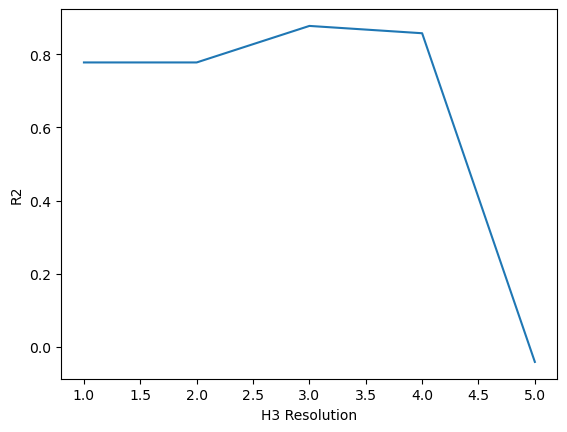

In [148]:
plt.plot(df_eval_resolution["resolution"], df_eval_resolution["r2"])
plt.xlabel("H3 Resolution")
plt.ylabel("R2")
plt.show()

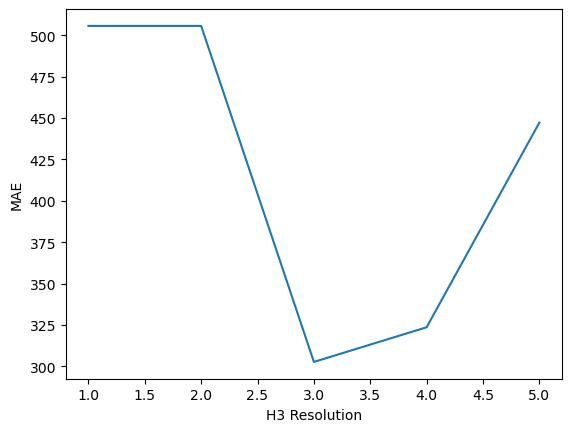

In [149]:
plt.plot(df_eval_resolution["resolution"], df_eval_resolution["MAE"])
plt.xlabel("H3 Resolution")
plt.ylabel("MAE")
plt.show()

#### 1.1.2 Different Time Dimensions

In [150]:
r2_test = []
mae_test = []
for time_bins in [1,2,6,24]:
    result = eval_svr(3,time_bins)
    r2_test.append(result["r2"]["test"])
    mae_test.append(result["MAE"]["test"])

In [151]:
df_eval_time = pd.DataFrame(
    {
        "time_bins": [1,2,6,24],
        "r2": r2_test,
        "MAE": mae_test
    }
)

In [152]:
r2_test

[0.8779337219399584,
 0.8560003699827838,
 0.8516636979893355,
 0.9061128194515844]

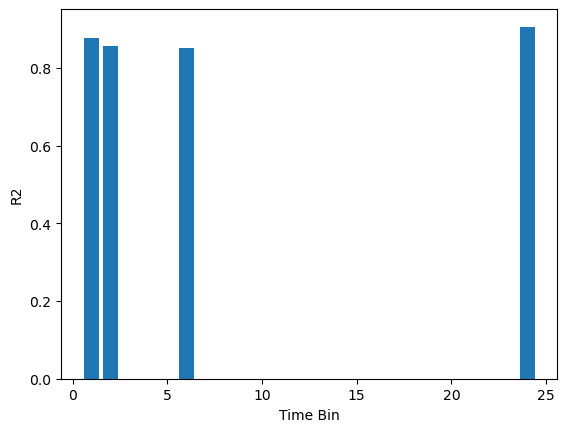

In [153]:
plt.bar(df_eval_time["time_bins"], df_eval_time["r2"])
plt.xlabel("Time Bin")
plt.ylabel("R2")
plt.show()

### 1.2 Fit SVR with POI as feature

#### 1.2.1 SVR with only one aggregated number of POI for each location

In [154]:
poi_by_hex = get_n_poi_for_resolution()

/Users/yassinehammou/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [155]:
poi_by_hex

,h3_3,n_poi
0,832664fffffffff,826848
1,832759fffffffff,1260


In [156]:
df_poi = df.merge(poi_by_hex, how="left", on="h3_3")

In [157]:
# split whole data
X_train_norm, X_test_norm, X_val_norm, y_train, y_test, y_val, X_train, X_test, X_val = prep_data(df_poi, True, 3)

{'MAE': {'train': 266.18863251834716, 'test': 299.2305097548167},
 'r2': {'train': 0.9072393435812529, 'test': 0.8778371159105324}}

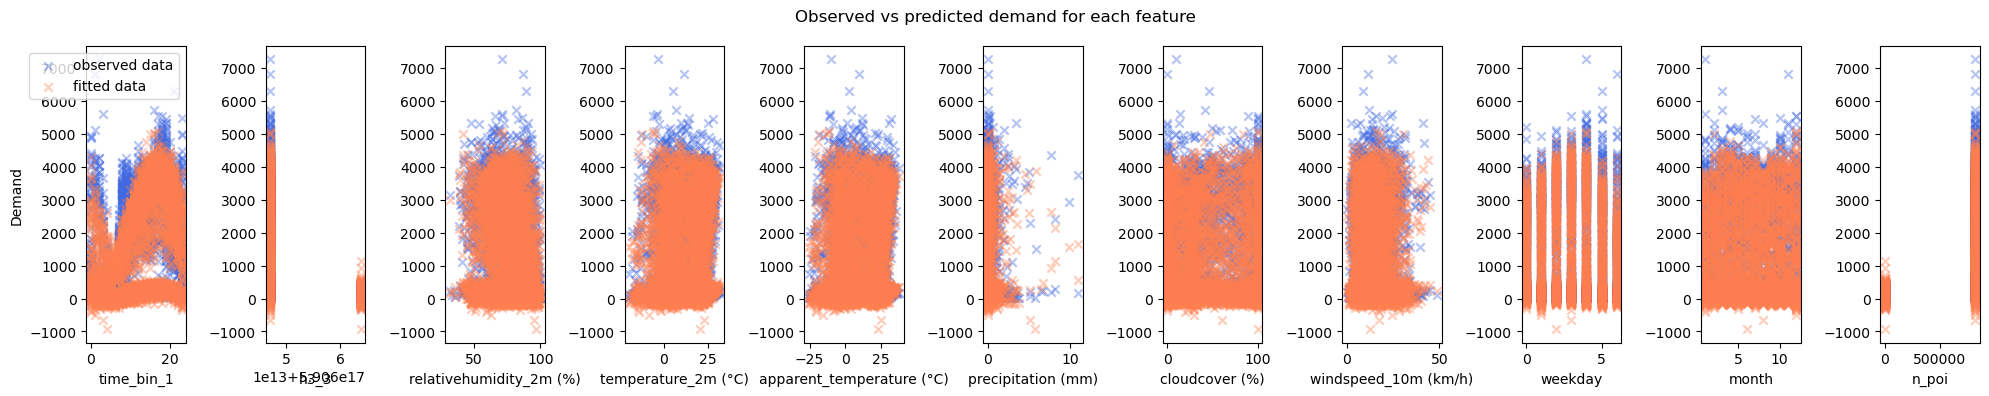

In [158]:
svr = SVR(kernel='rbf', epsilon=200 , gamma='scale', C=10000)

# Fit the SVR model
svr.fit(X_train_norm, y_train)

# Predict on the test set
y_pred_test = svr.predict(X_test_norm)
y_pred_train = svr.predict(X_train_norm)

# Evaluate the model
result = get_metrics(y_train, y_pred_train, y_test, y_pred_test)
display(result)

# Plot 
plot_matrix(X_test, y_test, X_test, y_pred_test)

In [159]:
# test for different resolutions

In [160]:
r2_test = []
mae_test = []
for resolution in range(1,6,1):
    result = eval_svr(resolution,1, True)
    r2_test.append(result["r2"]["test"])
    mae_test.append(result["MAE"]["test"])

/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_80831/954395966.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  result = eval_svr(resolution,1, True)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_80831/954395966.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  result = eval_svr(resolution,1, True)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_80831/954395966.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  result = eval_svr(resolution,1, True)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_80831/954395966.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  result = eval_

In [161]:
df_eval_resolution = pd.DataFrame(
    {
        "resolution": list(range(1,6,1)),
        "r2": r2_test,
        "MAE": mae_test
    }
)

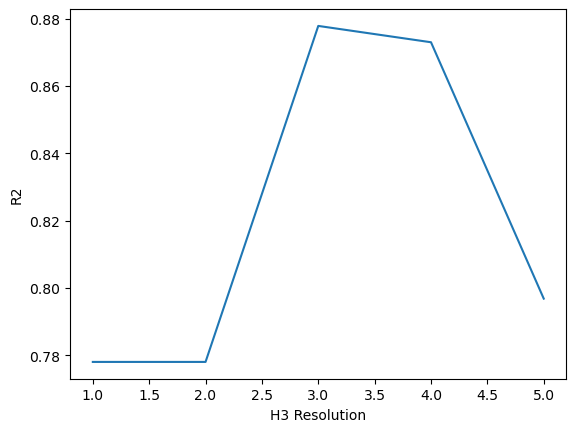

In [162]:
plt.plot(df_eval_resolution["resolution"], df_eval_resolution["r2"])
plt.xlabel("H3 Resolution")
plt.ylabel("R2")
plt.show()

#### 1.2.2 SVR with multiple seperate POI for each location

In [163]:
poi_by_hex = get_n_poi_for_resolution_and_amenity()

/Users/yassinehammou/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [164]:
poi_by_hex

,h3_3,bar,bus_station,car_rental,car_sharing,clinic,college,ferry_terminal,hospital,pharmacy,pub,university
0,832664fffffffff,466290,2970,19008,2376,51084,2376,20790,1188,55242,52866,5346
1,832759fffffffff,450,18,162,0,36,0,0,0,72,90,0


In [165]:
df_poi = df.merge(poi_by_hex, how="left", on="h3_3")

In [166]:
# split whole data
X_train_norm, X_test_norm, X_val_norm, y_train, y_test, y_val, X_train, X_test, X_val = prep_data(df_poi, True, 3)

In [167]:
svr = SVR(kernel='rbf', epsilon=200 , gamma='scale', C=10000)

# Fit the SVR model
svr.fit(X_train_norm, y_train)

# Predict on the test set
y_pred_test = svr.predict(X_test_norm)
y_pred_train = svr.predict(X_train_norm)

# Evaluate the model
result = get_metrics(y_train, y_pred_train, y_test, y_pred_test)
display(result)

{'MAE': {'train': 294.53671638222886, 'test': 311.668031762648},
 'r2': {'train': 0.8780924930153302, 'test': 0.8563404570968053}}

In [168]:
# test for different resolutions

In [169]:
r2_test = []
mae_test = []
for resolution in range(1,6,1):
    result = eval_svr(resolution,1, False, True)
    r2_test.append(result["r2"]["test"])
    mae_test.append(result["MAE"]["test"])

/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_80831/2548297801.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  result = eval_svr(resolution,1, False, True)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_80831/2548297801.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  result = eval_svr(resolution,1, False, True)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_80831/2548297801.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  result = eval_svr(resolution,1, False, True)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_80831/2548297801.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter 

In [170]:
df_eval_resolution = pd.DataFrame(
    {
        "resolution": list(range(1,6,1)),
        "r2": r2_test,
        "MAE": mae_test
    }
)

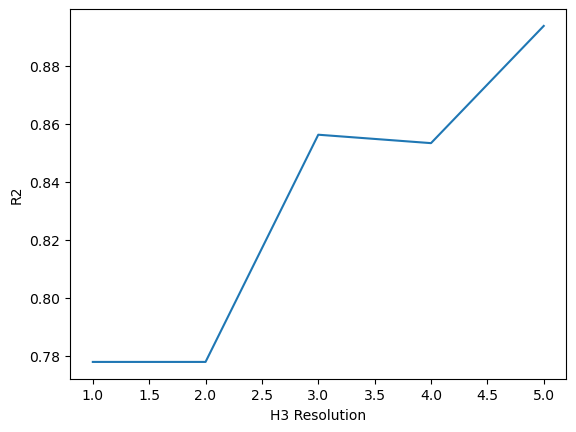

In [171]:
plt.plot(df_eval_resolution["resolution"], df_eval_resolution["r2"])
plt.xlabel("H3 Resolution")
plt.ylabel("R2")
plt.show()

## 2. Neural Network

In [172]:
def get_dl(batch_size, X_train_norm, X_test_norm, X_val_norm, y_train, y_test, y_val):
    '''Generate tensors from data and initialize dataloader.'''
    
    X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_norm, dtype=torch.float32)
    
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

    # Create a DataLoader for batching and shuffling your data during training
    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    test_ds = TensorDataset(X_test_tensor, y_test_tensor)
    val_ds = TensorDataset(X_val_tensor, y_val_tensor)

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True) 
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
    
    return (train_dl, test_dl, val_dl), (X_train_tensor, X_test_tensor, X_val_tensor, y_train_tensor, y_test_tensor, y_val_tensor)

In [173]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
  

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [174]:
def train(model, optimizer, train_dl, val_dl, epochs, loss_func, train_progress=True):
    '''Definition of the training loop of the neural network'''
    if train_progress:
        print("epoch  |    train loss   |  val loss ")
    
    for epoch in range(epochs):
        model.train()  # Set the model to train mode
        total_loss = 0
        
        for x, y in train_dl:
            x = x.to(device)
            y = y.to(device)

            # Forward pass
            y_hat = model(x)
            loss = loss_func(y_hat.flatten(), y)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        total_loss /= len(train_dl)

        # Validation
        model.eval()  # Set the model to evaluation mode
        total_loss_val = 0

        with torch.no_grad():
            for x, y in val_dl:
                x = x.to(device)
                y = y.to(device)

                y_hat = model(x)
                loss = loss_func(y_hat.flatten(), y)


                total_loss_val += loss.item()

            total_loss_val /= len(val_dl)
        
        if train_progress:    
            print("---------------------------------------------------")
            print(f"  {epoch}    |    {total_loss:.4f}  |  {total_loss_val:.4f}")

In [175]:
def nn_eval(model, X_train_tensor, X_test_tensor, X_test, y_train, y_test, display=True):
    model.eval()
    with torch.no_grad():
          y_pred_train = model(X_train_tensor.to(device))
          y_pred_test = model(X_test_tensor.to(device))

    y_pred_train = y_pred_train.cpu().numpy()
    y_pred_test = y_pred_test.cpu().numpy()


    # Evaluate the model
    result = get_metrics(y_train, y_pred_train, y_test, y_pred_test)
    
    if display:
        # Plot 
        plot_matrix(X_test, y_test, X_test, y_pred_test)
    
    return result

In [180]:
def eval_nn_for_different_resolutions(poi_agg, poi, output_size=1, learning_rate=0.05, batch_size=32, epochs=20, loss_func=nn.MSELoss()):
    r2 = []
    mae = []
    for resolution in range(1,7,1):
        path = f"prep_data/h3_{resolution}/h3_{resolution}_time_bin_1.csv"


        # load the data
        df = pd.read_csv(path, index_col=[0]).dropna()

        # add points of interest feature
        
        if poi_agg:
            poi_by_hex = get_n_poi_for_resolution(f"h3_{resolution}")
            df = df.merge(poi_by_hex, how="left", on=f"h3_{resolution}")
        elif poi:
            poi_by_hex = get_n_poi_for_resolution_and_amenity(f"h3_{resolution}")
            df = df.merge(poi_by_hex, how="left", on=f"h3_{resolution}")

        # split whole data
        X_train_norm, X_test_norm, X_val_norm, y_train, y_test, y_val, X_train, X_test, X_val = prep_data(df, True, resolution)

        # generate dataloader
        (train_dl, test_dl, val_dl), (X_train_tensor, X_test_tensor, X_val_tensor, y_train_tensor, y_test_tensor, y_val_tensor) = get_dl(batch_size, X_train_norm, X_test_norm, X_val_norm, y_train, y_test, y_val)

        # get model
        model = FeedforwardNN(X_train_norm.shape[1], output_size)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)

        # train model
        train(model, optimizer, train_dl, test_dl, epochs, loss_func, False)

        # eval model
        result = nn_eval(model, X_train_tensor, X_test_tensor, X_test, y_train, y_test, False)
        r2.append(result["r2"]["test"])
        mae.append(result["MAE"]["test"])
        
    return r2, mae

In [177]:
# Define the hyperparameters
input_size = 10  # Number of input features
output_size = 1  # Number of output neurons

learning_rate = 0.05
batch_size = 32
epochs = 20

loss_func = nn.MSELoss()

epoch  |    train loss   |  val loss 
---------------------------------------------------
  0    |    813587.0025  |  640604.7581
---------------------------------------------------
  1    |    631364.4490  |  543248.2443
---------------------------------------------------
  2    |    449706.9548  |  382333.3030
---------------------------------------------------
  3    |    366303.1810  |  350621.2463
---------------------------------------------------
  4    |    312883.9658  |  288811.3926
---------------------------------------------------
  5    |    283272.2964  |  302737.9114
---------------------------------------------------
  6    |    269863.7900  |  319314.9761
---------------------------------------------------
  7    |    246299.5713  |  261562.3919
---------------------------------------------------
  8    |    231544.4414  |  370197.3462
---------------------------------------------------
  9    |    217060.4317  |  217291.0806
------------------------------------------

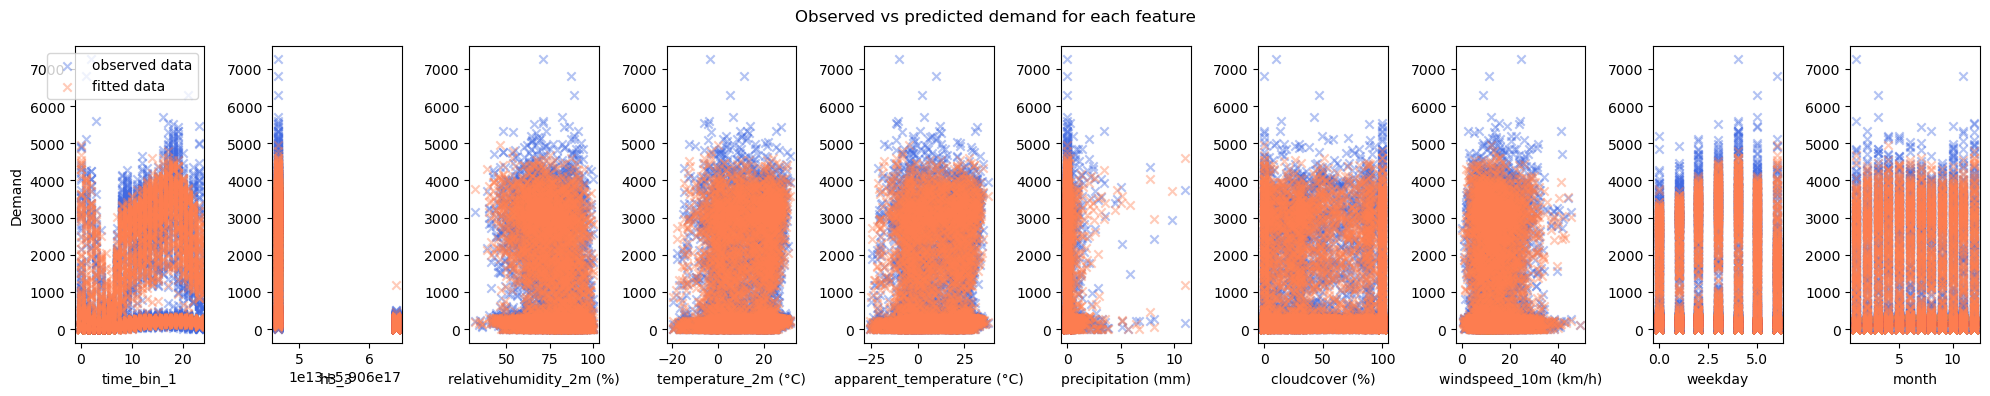

In [178]:
# load the data
df = pd.read_csv(f"prep_data/h3_3/h3_3_time_bin_1.csv", index_col=[0]).dropna()

# split whole data
X_train_norm, X_test_norm, X_val_norm, y_train, y_test, y_val, X_train, X_test, X_val = prep_data(df, True, 3)

# generate dataloader
(train_dl, test_dl, val_dl), (X_train_tensor, X_test_tensor, X_val_tensor, y_train_tensor, y_test_tensor, y_val_tensor) = get_dl(batch_size, X_train_norm, X_test_norm, X_val_norm, y_train, y_test, y_val)


# get model
model = FeedforwardNN(input_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# train model
train(model, optimizer, train_dl, test_dl, epochs, loss_func)

# eval model
result = nn_eval(model, X_train_tensor, X_test_tensor, X_test, y_train, y_test, True)

### 2.1 Fit NN for different data

#### 2.1.1 Different Location Dimensions

In [182]:
r2, mae = eval_nn_for_different_resolutions(False, False)

In [183]:
r2

[0.792537005757331,
 0.8063455516920344,
 0.9176977318925755,
 0.8853197410115987,
 0.061774738842447996,
 0.019700284300077198]

In [184]:
df_eval_resolution = pd.DataFrame(
    {
        "resolution": list(range(1,7,1)),
        "r2": r2,
        "MAE": mae
    }
)

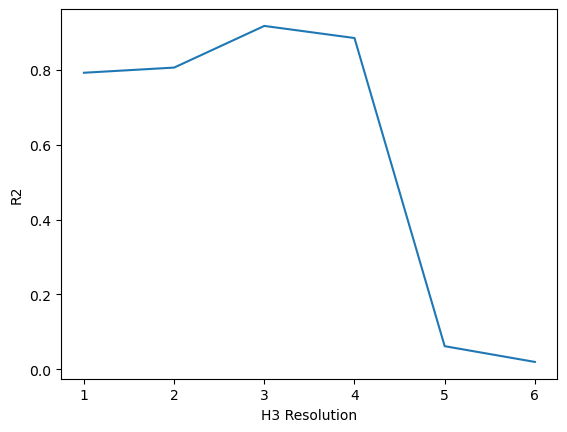

In [185]:
plt.plot(df_eval_resolution["resolution"], df_eval_resolution["r2"])
plt.xlabel("H3 Resolution")
plt.ylabel("R2")
plt.show()

#### 2.1.2 Different Time Dimensions

In [186]:
# Define the hyperparameters
input_size = 10  # Number of input features
output_size = 1  # Number of output neurons

learning_rate = 0.05
batch_size = 32
epochs = 20

loss_func = nn.MSELoss()

In [187]:
r2 = []
mae = []
for time_bin in [1,2,6,24]:
    path = f"prep_data/h3_3/h3_3_time_bin_{time_bin}.csv"
    
    
    # load the data
    df = pd.read_csv(path, index_col=[0]).dropna()

    # split whole data
    X_train_norm, X_test_norm, X_val_norm, y_train, y_test, y_val, X_train, X_test, X_val = prep_data(df, True, 3)

    # generate dataloader
    (train_dl, test_dl, val_dl), (X_train_tensor, X_test_tensor, X_val_tensor, y_train_tensor, y_test_tensor, y_val_tensor) = get_dl(batch_size, X_train_norm, X_test_norm, X_val_norm, y_train, y_test, y_val)

    # get model
    model = FeedforwardNN(input_size, output_size)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # train model
    train(model, optimizer, train_dl, test_dl, epochs, loss_func, False)

    # eval model
    result = nn_eval(model, X_train_tensor, X_test_tensor, X_test, y_train, y_test, False)
    r2.append(result["r2"]["test"])
    mae.append(result["MAE"]["test"])

In [188]:
r2

[0.9149273711321029, 0.847935684061728, 0.7314098290092123, 0.8749662774946954]

In [189]:
df_eval_resolution = pd.DataFrame(
    {
        "time_bins": [1,2,6,24],
        "r2": r2,
        "MAE": mae
    }
)

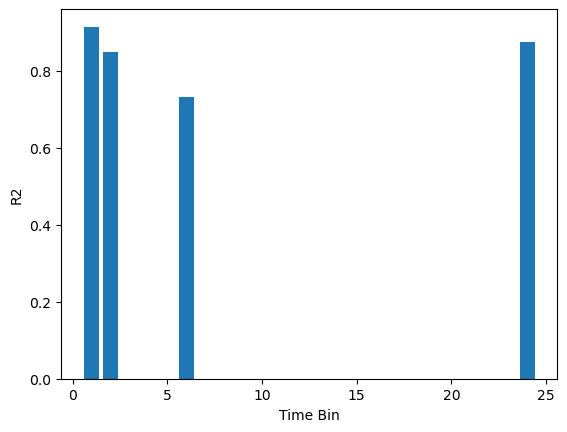

In [190]:
plt.bar(df_eval_resolution["time_bins"], df_eval_resolution["r2"])
plt.xlabel("Time Bin")
plt.ylabel("R2")
plt.show()

### 2.2 Fit on data where zero demand is allowed

In [191]:
# load data
df = pd.read_csv("h3_5_time_bin_1_zero.csv", index_col=[0]).drop(columns=["time", "hour"])

epoch  |    train loss   |  val loss 
---------------------------------------------------
  0    |    596834.3589  |  582798.8862
---------------------------------------------------
  1    |    587698.3291  |  579622.0111
---------------------------------------------------
  2    |    582825.6210  |  574726.2512
---------------------------------------------------
  3    |    581645.5222  |  574620.6801
---------------------------------------------------
  4    |    578915.1798  |  572438.5233
---------------------------------------------------
  5    |    578419.2031  |  572047.9483
---------------------------------------------------
  6    |    577215.8384  |  571315.9180
---------------------------------------------------
  7    |    576639.5319  |  571105.9390
---------------------------------------------------
  8    |    575795.4829  |  570892.4685
---------------------------------------------------
  9    |    576084.6315  |  569405.4808
------------------------------------------

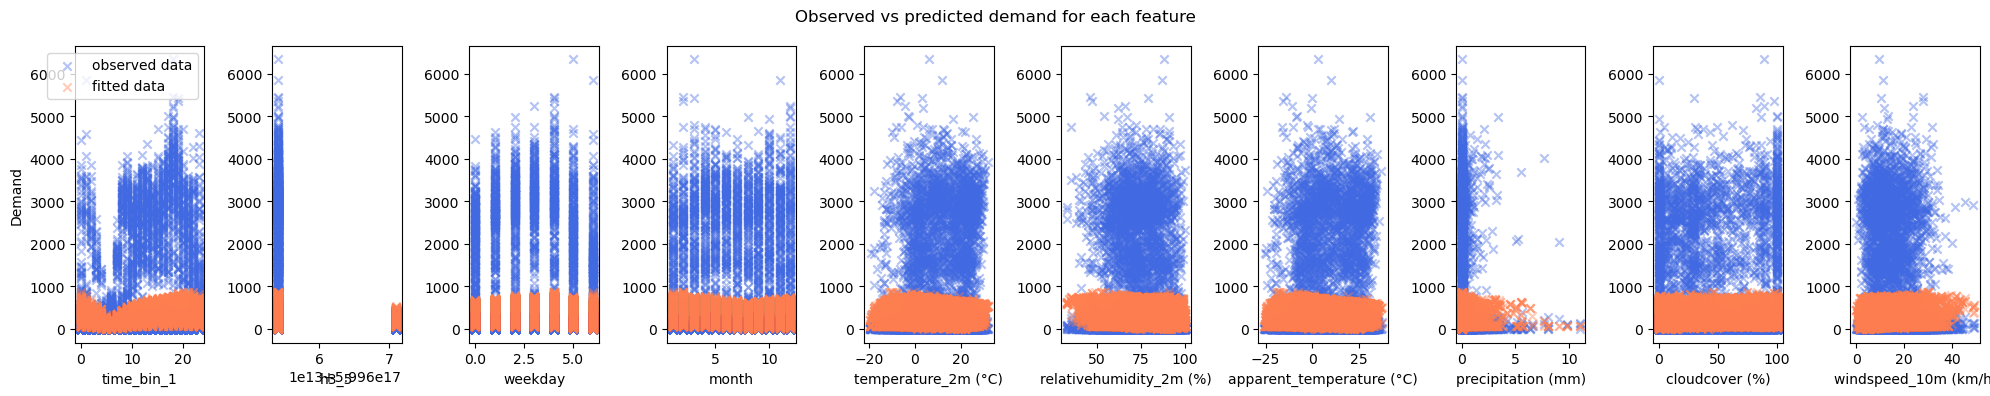

In [192]:
# split whole data
X_train_norm, X_test_norm, X_val_norm, y_train, y_test, y_val, X_train, X_test, X_val = prep_data(df, True, 5)

# generate dataloader
(train_dl, test_dl, val_dl), (X_train_tensor, X_test_tensor, X_val_tensor, y_train_tensor, y_test_tensor, y_val_tensor) = get_dl(batch_size, X_train_norm, X_test_norm, X_val_norm, y_train, y_test, y_val)


# get model
model = FeedforwardNN(input_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# train model
train(model, optimizer, train_dl, test_dl, epochs, loss_func)

# eval model
result = nn_eval(model, X_train_tensor, X_test_tensor, X_test, y_train, y_test, True)

In [193]:
print(result)

{'MAE': {'train': 453.97170424666973, 'test': 454.2329355832827}, 'r2': {'train': 0.04331616462059429, 'test': 0.03500106170756756}}


Allowing a trip demand of zero does not allow for better performance. Therefore it can be seen that the H3 resolution of 5 is to high for the model.

### 2.3 Fit NN with POI as feature

#### 2.3.1 NN with only one aggregated number of POI for each location

In [194]:
r2, mae = eval_nn_for_different_resolutions(True, False)

/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_80831/4049416234.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  r2, mae = eval_nn_for_different_resolutions(True, False)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_80831/4049416234.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  r2, mae = eval_nn_for_different_resolutions(True, False)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_80831/4049416234.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  r2, mae = eval_nn_for_different_resolutions(True, False)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_80831/4049416234.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. P

In [195]:
df_eval_resolution = pd.DataFrame(
    {
        "resolution": list(range(1,7,1)),
        "r2": r2,
        "MAE": mae
    }
)

In [196]:
df_eval_resolution

,resolution,r2,MAE
0,1,0.783282,496.411504
1,2,0.765294,501.867956
2,3,0.910137,229.712955
3,4,0.915210,227.295035
4,5,0.939656,94.810095
5,6,0.933104,94.501826


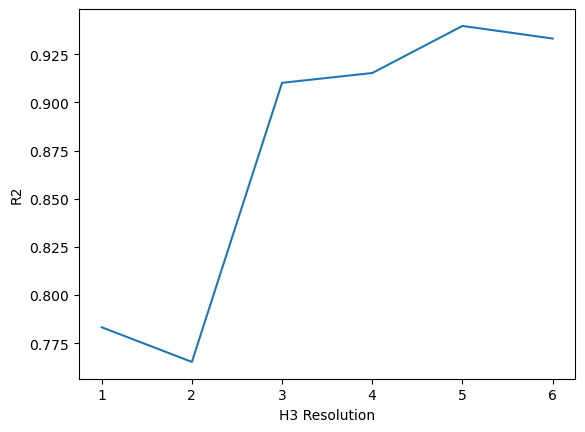

In [197]:
plt.plot(df_eval_resolution["resolution"], df_eval_resolution["r2"])
plt.xlabel("H3 Resolution")
plt.ylabel("R2")
plt.show()

#### 2.3.2 NN with multiple seperate POI for each locations

In [198]:
r2, mae = eval_nn_for_different_resolutions(False, True)

/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_80831/3870951707.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  r2, mae = eval_nn_for_different_resolutions(False, True)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_80831/3870951707.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  r2, mae = eval_nn_for_different_resolutions(False, True)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_80831/3870951707.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  r2, mae = eval_nn_for_different_resolutions(False, True)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_80831/3870951707.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. P

In [199]:
df_eval_resolution = pd.DataFrame(
    {
        "resolution": list(range(1,7,1)),
        "r2": r2,
        "MAE": mae
    }
)

In [200]:
df_eval_resolution

,resolution,r2,MAE
0,1,0.734814,545.391775
1,2,0.761158,512.658767
2,3,0.902705,238.228301
3,4,0.895832,264.877267
4,5,0.945038,87.112750
5,6,0.945868,74.728364


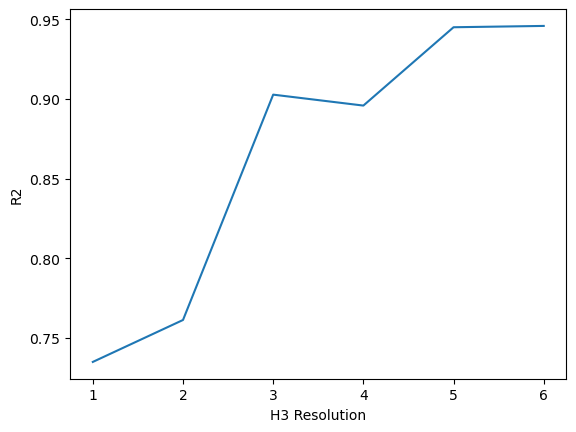

In [201]:
plt.plot(df_eval_resolution["resolution"], df_eval_resolution["r2"])
plt.xlabel("H3 Resolution")
plt.ylabel("R2")
plt.show()

## Test RegressionTree

In [202]:
from sklearn.tree import DecisionTreeRegressor

In [203]:
reg_tree = DecisionTreeRegressor(random_state=42)
reg_tree.fit(X_train_norm, y_train)

DecisionTreeRegressor(random_state=42)

In [204]:
y_pred_test = reg_tree.predict(X_test_norm)
y_pred_train = reg_tree.predict(X_train_norm)

{'MAE': {'train': 0.0, 'test': 529.8920880371882},
 'r2': {'train': 1.0, 'test': -1.1381365504503926}}

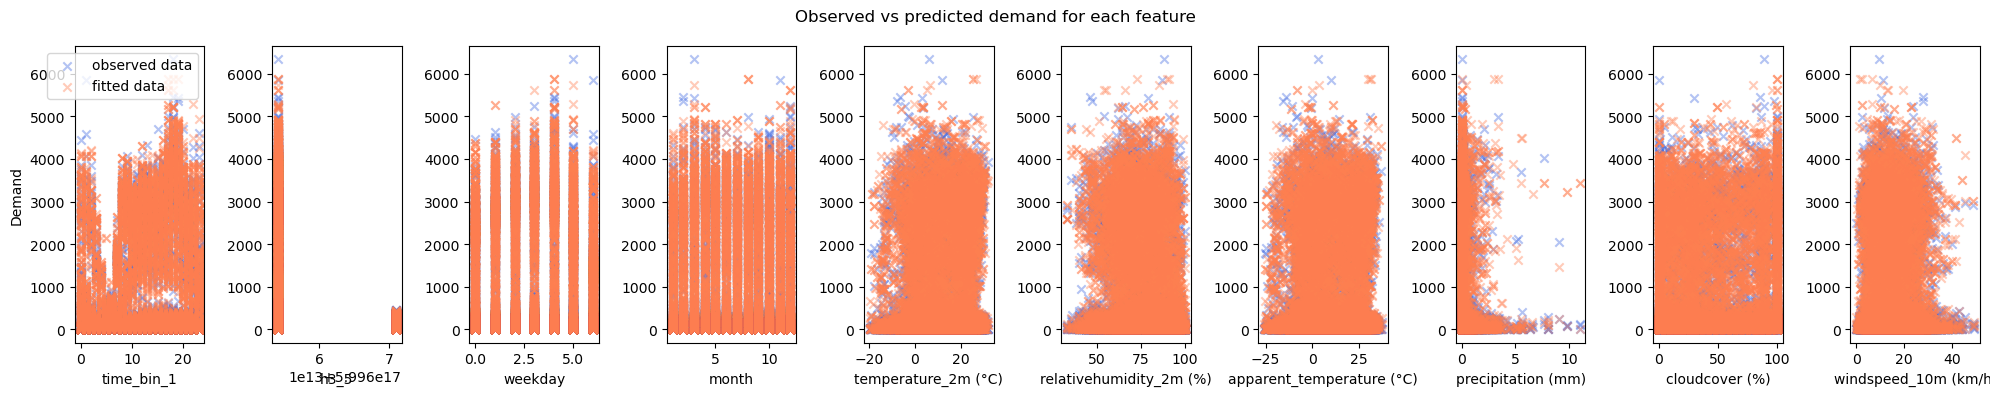

In [205]:
# Evaluate the model
result = get_metrics(y_train, y_pred_train, y_test, y_pred_test)
display(result)
# Plot 
plot_matrix(X_test, y_test, X_test, y_pred_test)